In [208]:
# try everything here
import sys
sys.path.append('../')

# other
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# utils
from src.data.make_dataset import load_data, merge_all_datasets
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')



In [209]:
# Loading Data
data_dict = load_data()

olist_customers_df = data_dict['olist_customers_df']
olist_geolocation_df = data_dict['olist_geolocation_df']
olist_order_items_df = data_dict['olist_order_items_df']
olist_order_payments_df = data_dict['olist_order_payments_df']
olist_order_reviews_df = data_dict['olist_order_reviews_df']
olist_orders_df = data_dict['olist_orders_df']
olist_products_df = data_dict['olist_products_df']
olist_sellers_df = data_dict['olist_sellers_df']
product_category_name_translation_df = data_dict['product_category_name_translation_df']

olist_closed_deals_df = data_dict['olist_closed_deals_df']
olist_marketing_qualified_leads_df = data_dict['olist_marketing_qualified_leads_df']

In [210]:
# Merging into one
df = merge_all_datasets(olist_customers_df, 
                       olist_geolocation_df,
                       olist_order_items_df,
                       olist_order_payments_df,
                       olist_order_reviews_df, 
                       olist_orders_df,
                       olist_products_df, 
                       olist_sellers_df, 
                       olist_closed_deals_df, 
                       olist_marketing_qualified_leads_df)

### Questions to explore

- Did a customer that purchased an item and received a delayed delivery purchase again?
- Are delayed deliveries purchased less?
- How do I connect a review of a random customer with new customers?
- Research on how does causal inference work on a "future" timeline.
- What are possible confounders?
- What are possible confounders that don’t exist in our data?

In [211]:
#### Average difference in ratings between those deliveries that were late and those that were on time

df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['late_delivery_in_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

# if late_delivery_in_days > 0, then delivery was late
df['is_delivery_late'] = np.where(df['late_delivery_in_days'] > 0, 1, 0)
df.groupby("is_delivery_late")['review_score'].mean()



is_delivery_late
0    4.132788
1    2.253393
Name: review_score, dtype: float64

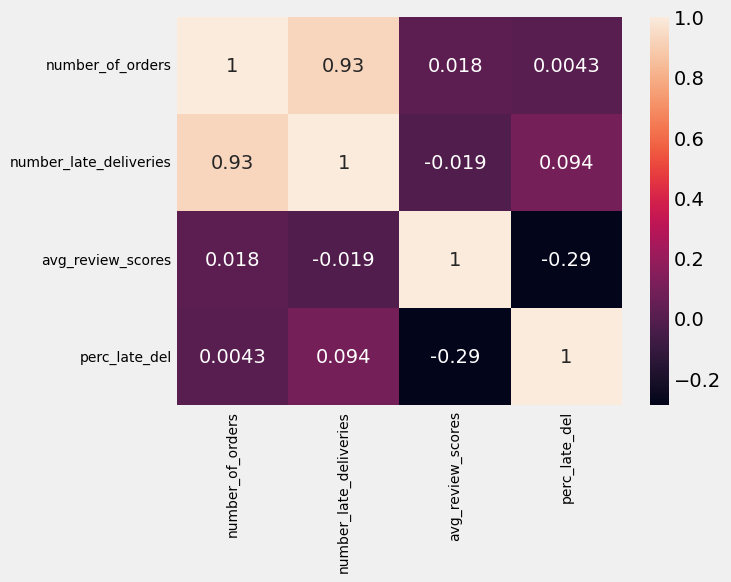

In [221]:
####  Do average review score correlate with late deliveries?

agg_df = df.groupby('seller_id').agg(
        number_of_orders=('order_id', 'count'), 
        number_late_deliveries=('is_delivery_late', 'sum'), 
        avg_review_scores=('review_score', 'mean'))\
        .reset_index().sort_values(by='number_late_deliveries', ascending=False)

agg_df['perc_late_del'] = agg_df['number_late_deliveries'] / agg_df['number_of_orders']
sns.heatmap(agg_df.iloc[:,1:].corr(), annot=True)
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)
plt.show()  

- As a seller, the more order you have the more likely you're to have late deliveries
- The higher the percentage of late deliveries as a seller, the more it impacts your average review score

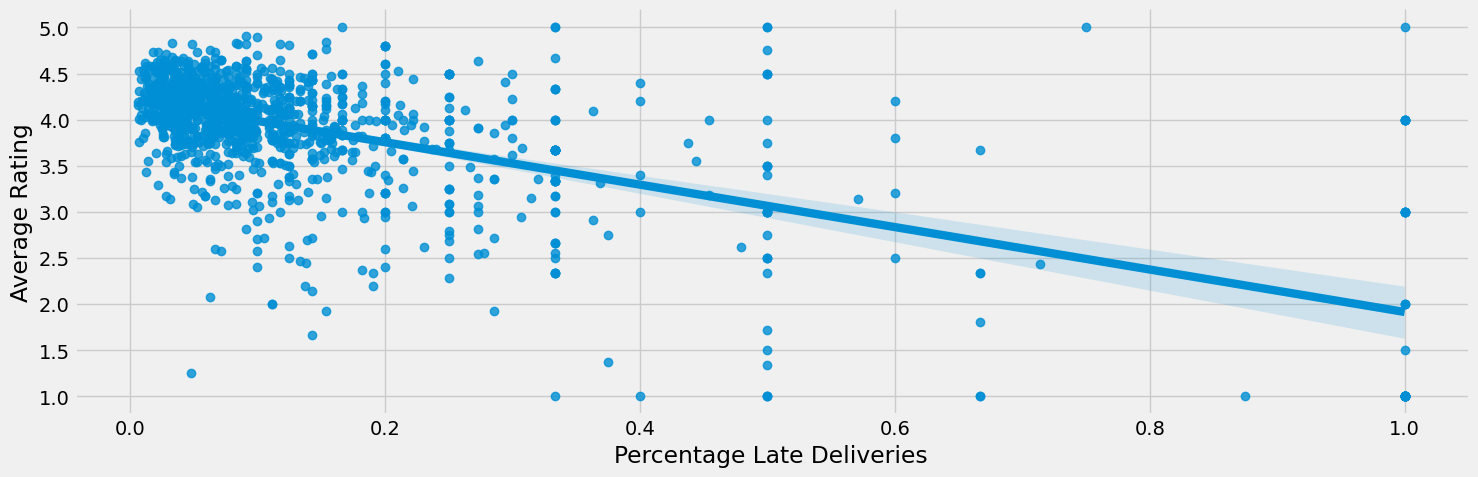

In [251]:
sns.lmplot(agg_df[agg_df["perc_late_del"] > 0], x='perc_late_del', y='avg_review_scores', height=5, aspect=3)
plt.ylabel("Average Rating")
plt.xlabel("Percentage Late Deliveries")
plt.show()

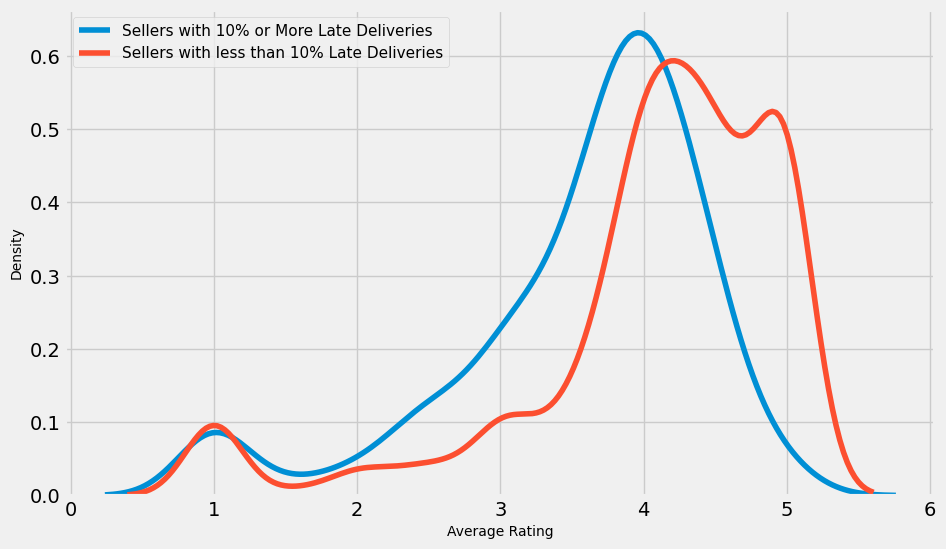

In [250]:
plt.figure(figsize=(10,6))
sns.kdeplot(agg_df[agg_df['perc_late_del'] >= 0.1]['avg_review_scores'], label='Sellers with 10% or More Late Deliveries')
sns.kdeplot(agg_df[agg_df['perc_late_del'] < 0.1]['avg_review_scores'], label='Sellers with less than 10% Late Deliveries')
plt.xlabel("Average Rating", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=11)
plt.show()

---

What are some of the variables that could be affecting late deliveries and ratings?


1. Distance between seller and customer affects late deliveries

2. Product (product category, size, price) affects late deliveries and ratings
3. Product quality affects ratings 
4. Season (months of the year) affects late deliveries
5. Shipping method affects both late deliveries and ratings
6. Weather affects late delivery
7. Customer service experience affects ratings